In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!git clone https://github.com/SebastianRiquelmeM/dataset_iris_flowers.git
!rm -r dataset_iris_flowers/.git

Cloning into 'dataset_iris_flowers'...
remote: Enumerating objects: 410, done.
remote: Counting objects: 100% (410/410), done.
remote: Compressing objects: 100% (410/410), done.
remote: Total 410 (delta 0), reused 410 (delta 0), pack-reused 0
Receiving objects: 100% (410/410), 5.05 MiB | 16.75 MiB/s, done.


In [3]:
#base_dir = "../input/flowers-recognition/flowers/flowers"
base_dir = "dataset_iris_flowers"
os.listdir(base_dir)

['iris-versicolour', 'iris-setosa', 'iris-virginica']

In [4]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
dataset = ImageFolder(base_dir, transform=transformer)


In [5]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  iris-setosa (0)


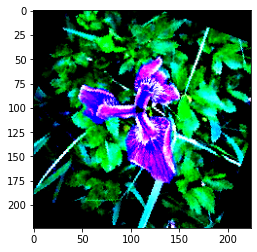

In [6]:
show_example(*dataset[1])

In [7]:
cantidad_datos = len(dataset)
#validation_size = 500
validation_size = int(cantidad_datos*0.4)
#training_size = len(dataset) - validation_size
training_size = cantidad_datos - validation_size

In [8]:
dataset.classes

['iris-setosa', 'iris-versicolour', 'iris-virginica']

In [9]:
train_ds, val_ds_main = random_split(dataset,[training_size, validation_size])
#val_ds, test_ds  = random_split(val_ds_main,[300, 200])
val_ds, test_ds  = random_split(val_ds_main,[int(validation_size/2), int(validation_size/2)])
print("train: ", len(train_ds),"validation: ", len(val_ds), "test: ",len(test_ds))

train:  253 validation:  84 test:  84


Label:  iris-setosa (0)


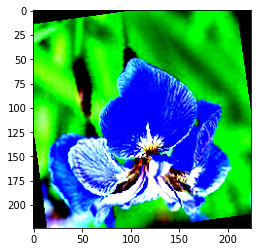

In [10]:
show_example(*train_ds[1])

In [11]:
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 32)
test_dl = DataLoader(test_ds, batch_size = 32)

In [12]:
print(dataset.classes)

['iris-setosa', 'iris-versicolour', 'iris-virginica']


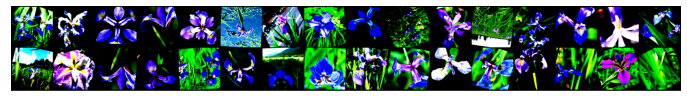

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
        
    def forward(self, xb):
        return self.network(xb)
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
model = ImageClassificationModel()
model

ImageClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Lin

In [16]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 224, 224])
out.shape: torch.Size([32, 5])
out[0]: tensor([-0.0275, -0.0024, -0.0169, -0.0053,  0.0204],
       grad_fn=<SelectBackward0>)


In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [20]:
model = to_device(ImageClassificationModel(), device)
evaluate(model, val_dl)

{'val_loss': 1.5998566150665283, 'val_acc': 0.699999988079071}

In [21]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [22]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.4757, val_loss: 0.8570, val_acc: 0.7000
Epoch [1], train_loss: 1.0183, val_loss: 0.8215, val_acc: 0.7000
Epoch [2], train_loss: 0.9708, val_loss: 0.8117, val_acc: 0.7000
Epoch [3], train_loss: 0.9436, val_loss: 0.8963, val_acc: 0.7000
Epoch [4], train_loss: 0.9279, val_loss: 0.7954, val_acc: 0.7000
Epoch [5], train_loss: 0.8861, val_loss: 0.8074, val_acc: 0.6729
Epoch [6], train_loss: 0.8921, val_loss: 0.8127, val_acc: 0.7000
Epoch [7], train_loss: 0.8926, val_loss: 0.8308, val_acc: 0.7063
Epoch [8], train_loss: 0.8532, val_loss: 0.7752, val_acc: 0.6937
Epoch [9], train_loss: 0.8518, val_loss: 0.8134, val_acc: 0.6729


In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

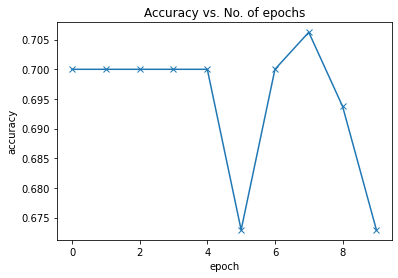

In [24]:
plot_accuracies(history)

In [25]:
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_loss': 0.9388773441314697, 'val_acc': 0.59375}

In [26]:
import torchvision.models as models
class ImageClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [27]:
model = to_device(ImageClassificationModel(), device)
evaluate(model, val_dl)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

{'val_loss': 1.804168701171875, 'val_acc': 0.0}

In [28]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.4579, val_loss: 1.7306, val_acc: 0.1812
Epoch [1], train_loss: 1.2013, val_loss: 1.1856, val_acc: 0.7063
Epoch [2], train_loss: 1.1798, val_loss: 1.2831, val_acc: 0.5542
Epoch [3], train_loss: 1.1684, val_loss: 1.4316, val_acc: 0.3667
Epoch [4], train_loss: 1.1364, val_loss: 1.2822, val_acc: 0.5312
Epoch [5], train_loss: 1.1384, val_loss: 1.2530, val_acc: 0.5417
Epoch [6], train_loss: 1.1389, val_loss: 1.3091, val_acc: 0.5729
Epoch [7], train_loss: 1.1354, val_loss: 1.3157, val_acc: 0.4771
Epoch [8], train_loss: 1.1575, val_loss: 1.2634, val_acc: 0.4979
Epoch [9], train_loss: 1.1074, val_loss: 1.3604, val_acc: 0.4646


In [29]:
evaluate(model, test_dl)

{'val_loss': 1.287354826927185, 'val_acc': 0.5374999642372131}

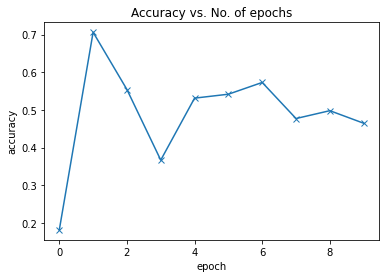

In [30]:
plot_accuracies(history)

In [31]:
weights_fname = 'flower-resnet.pth'
torch.save(model.state_dict(), weights_fname)

Label: iris-versicolour , Predicted: iris-virginica


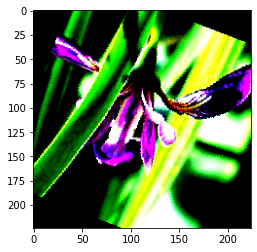

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = test_ds[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [33]:
!pip install jovian --quiet

     |████████████████████████████████| 68 kB 6.6 MB/s 


In [34]:
import jovian

In [35]:

jovian.commit(project='Flower Classification',environment=None, outputs=[weights_fname])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
